In [1]:
%matplotlib inline 
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
sns.set_style('ticks')
default_colors = sns.color_palette(); 

# Adjust all text and axes colors to black. default is some studip gray that appears to faint when printed 
from matplotlib import rc , rcParams
rc('axes',edgecolor='black')
rc('xtick',color='black',labelsize=15)
rc('ytick',color='black',labelsize=15)
rc('text',color='black')
rc('axes',labelcolor='black',linewidth=2.0)
rc('font',size=15)
#rcParams["patch.force_edgecolor"] = True



import Calculate_ABA_Flinkelsteinlab as CalcABA
reload(CalcABA);

### Load Parameters

In [2]:
model_id = 'init_limit_general_energies_v2'
filename = '../data/25_10_2018/median_landscape_Boyle.txt'
boyle_params = np.loadtxt(filename,comments='#')

### Load data

In [3]:
import sys
sys.path.append('../code_ABA_Finkelsteinlab/')
import plotting_ABA as pltABA
reload(pltABA);


IlyaData = pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv')

### Prediction

In [4]:
def predict_block_mismatches(parameters, model_id, T=60*10,guide_length=20, show_plot=True, show_data=True):
    concentrations = 2**np.array(range(0,11))*0.5
    reference_conc = 10
    ontarget_ABA = CalcABA.calc_ABA(parameters, concentrations, reference_conc, 
                 mismatch_positions=[], 
                 model_id=model_id, 
                 guide_length=20, 
                 T=60*10)


    delta_ABA_mat = np.zeros((guide_length,guide_length))
    delta_ABA_mat[:] = np.nan
    
    
    for start_of_block in range(1,guide_length+1):
        for end_of_block in range(start_of_block+2,guide_length+1):
            mm_block = range(start_of_block,end_of_block)
            delta_ABA_mat[start_of_block-1,end_of_block-1] = CalcABA.calc_delta_ABA(parameters, concentrations, reference_conc, 
                     mismatch_positions=mm_block, 
                     model_id=model_id, 
                     guide_length=guide_length, 
                     T=T,
                     ontarget_ABA=ontarget_ABA)
    
    
    if show_plot:
        ax = sns.heatmap(delta_ABA_mat,cmap='coolwarm', vmin=0, vmax=2.5)
        plt.grid()
        ax.set_xticklabels(map(lambda x: str(int(x)), ax.get_xticks() + 0.5),fontsize=15);
        ax.set_yticklabels(map(lambda x: str(int(x)), 20 -ax.get_yticks() + 0.5), fontsize=15,rotation=0);
        plt.xlabel('Block end', fontsize=15)
        plt.ylabel('Block start', fontsize=15)
        plt.title('Prediction', fontsize=15)
        
        if show_data:
            plt.figure()
            IlyaData = pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv')
            _, Blocks_heatmap,_ = pltABA.plot_block_mm_ABA(IlyaData, 
                                                               Plot=False,
                                                               SaveFigures=False,
                                                               figure_names=[''])
            sns.heatmap(Blocks_heatmap, cmap='coolwarm',  vmin=0, vmax=2.5)
            plt.grid()
            plt.xlabel('Block end', fontsize=15)
            plt.ylabel('Block start', fontsize=15)
            plt.title('Data', fontsize=15)
        
    return delta_ABA_mat


def predict_1D_mmblocks(parameters, model_id, T=60*10,guide_length=20, show_plot=True, show_data=True):
    concentrations = 2**np.array(range(0,11))*0.5
    reference_conc = 10
    ontarget_ABA = CalcABA.calc_ABA(parameters, concentrations, reference_conc, 
                 mismatch_positions=[], 
                 model_id=model_id, 
                 guide_length=20, 
                 T=60*10)


    delta_ABA_mat = np.zeros(guide_length-2)
    for start_of_block in range(1,guide_length-1):
        avg_delta_ABA = 0
        count = 0 
        for end_of_block in range(start_of_block+2,guide_length+1):
            mm_block = range(start_of_block,end_of_block)
            avg_delta_ABA += CalcABA.calc_delta_ABA(parameters, concentrations, reference_conc, 
                     mismatch_positions=mm_block, 
                     model_id=model_id, 
                     guide_length=guide_length, 
                     T=T,
                     ontarget_ABA=ontarget_ABA)
            count += 1 

        delta_ABA_mat[start_of_block-1] = avg_delta_ABA / float(count) 
        
        
    if show_plot:
        ax = plt.plot(range(1,guide_length-1),
                      delta_ABA_mat,
                     marker='o',
                     markersize=4,
                     markerfacecolor='white',
                     markeredgewidth=2,
                     linestyle='solid',
                     label='prediction model')
        
        
        sns.despine()
        plt.xticks(range(1,19),fontsize=15);
        plt.yticks(fontsize=15);
        plt.xlabel('start of mismatched block',fontsize=15);
        plt.ylabel(r'$\Delta \rm{ABA} \ (k_BT)$',fontsize=15)
    
        if show_data:
        
            IlyaData = pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv')

            _,_,ABA_first_mm_pos = pltABA.plot_block_mm_ABA(IlyaData, 
                                                               Plot=False,
                                                               SaveFigures=False,
                                                               figure_names=[]);
        
        
            plt.errorbar(x=ABA_first_mm_pos['Block start'], 
                 y=ABA_first_mm_pos['Delta ABA (kBT)'], 
                 yerr=ABA_first_mm_pos['Uncertainty'],
                        marker='o',
                         markersize=4,
                         markerfacecolor='white',
                         markeredgewidth=2,
                         linestyle='solid',
                         capsize=5,
                         label='data Finkelstein lab'
                            )
            plt.legend(fontsize=15, loc='best')
    return delta_ABA_mat




def predict_single_mm(parameters, model_id, T=60*10,guide_length=20, show_plot=True,show_data=True):
    concentrations = 2**np.array(range(0,11))*0.5
    reference_conc = 10
    ontarget_ABA = CalcABA.calc_ABA(parameters, concentrations, reference_conc, 
                 mismatch_positions=[], 
                 model_id=model_id, 
                 guide_length=20, 
                 T=60*10)
    
    
    delta_ABA = np.zeros(guide_length)
    for mm_pos in range(1,guide_length+1):
        delta_ABA[mm_pos-1] = CalcABA.calc_delta_ABA(parameters, concentrations, reference_conc, 
                     mismatch_positions=[mm_pos], 
                     model_id=model_id, 
                     guide_length=guide_length, 
                     T=T,
                     ontarget_ABA=ontarget_ABA)
    
    if show_plot:
        ax = plt.plot(range(1,guide_length+1),
                      delta_ABA,
                     marker='o',
                     markersize=4,
                     markerfacecolor='white',
                     markeredgewidth=2,
                     linestyle='solid',
                     label='prediction model')
        
        
        sns.despine()
        plt.xticks(range(1,19),fontsize=15);
        plt.yticks(fontsize=15);
        plt.xlabel('mismatch position',fontsize=15);
        plt.ylabel(r'$\Delta \rm{ABA} \ (k_BT)$',fontsize=15)
        
        if show_data:
            IlyaData = pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv')
            single_mut_data_mean= pltABA.plot_single_mut_ABA(data=IlyaData,Mut_type='r', Plot=False)
            
            
            plt.errorbar(x=single_mut_data_mean['Position'], 
                                      y=single_mut_data_mean['Delta ABA (kBT)'], 
                                      yerr=single_mut_data_mean['Uncertainty'], 
                                     marker='o',
                                     markersize=4,
                                     markerfacecolor='white',
                                     markeredgewidth=2,
                                     linestyle='solid',
                                     label='data Finkelstein lab')
            plt.legend(fontsize=15, loc='best')
    return delta_ABA




def predict_double_mm(parameters, model_id, T=60*10,guide_length=20, show_plot=True,show_data=True):
    concentrations = 2**np.array(range(0,11))*0.5
    reference_conc = 10
    ontarget_ABA = CalcABA.calc_ABA(parameters, concentrations, reference_conc, 
                 mismatch_positions=[], 
                 model_id=model_id, 
                 guide_length=20, 
                 T=60*10)
    
    delta_ABA_mat =np.zeros((guide_length,guide_length))
    for first_mm in range(1,guide_length+1):
        for second_mm in range(1,guide_length+1):
            delta_ABA_mat[first_mm-1,second_mm-1] = CalcABA.calc_delta_ABA(parameters, concentrations, reference_conc, 
                     mismatch_positions=[first_mm,second_mm], 
                     model_id=model_id, 
                     guide_length=guide_length, 
                     T=T,
                     ontarget_ABA=ontarget_ABA)
    
    if show_plot:
        axHeatmap = sns.heatmap(delta_ABA_mat, cmap='coolwarm',mask=np.tril(delta_ABA_mat), vmin=0, vmax=2.5)
        plt.grid()
        ax = plt.gca()
        ax.set_xticklabels(map(lambda x: str(int(x)), ax.get_xticks() + 0.5),fontsize=15);
        ax.set_yticklabels(map(lambda x: str(int(x)), 20 -ax.get_yticks() + 0.5), fontsize=15,rotation=0);
        str_title = 'Prediction (top)'
        
        
        if show_data:
            IlyaData = pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv')
            _,double_mut_map = pltABA.plot_double_mut_ABA(data=IlyaData,Mut_type='r',Plot=False)
            sns.heatmap(double_mut_map, cmap='coolwarm',ax=axHeatmap, vmin=0, vmax=2.5)
            str_title += ' / Data (bottom)'
        plt.title(str_title, fontsize=15)
        plt.xlabel('Mismatch 1', fontsize=15)
        plt.ylabel('Mismatch 2', fontsize=15)
    return delta_ABA_mat

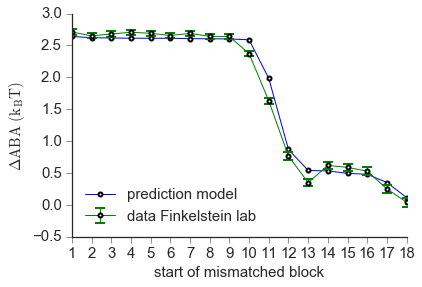

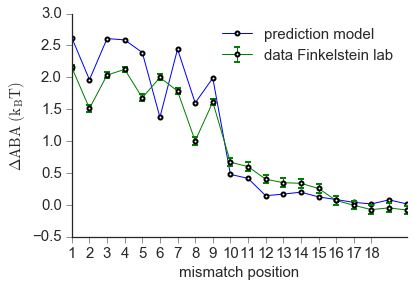

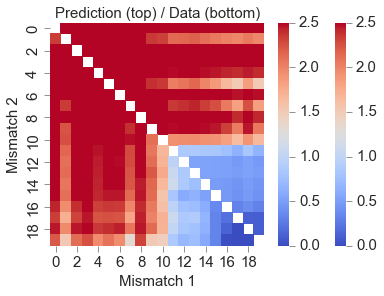

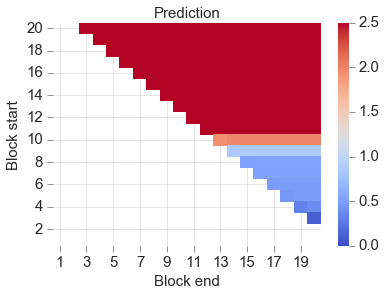

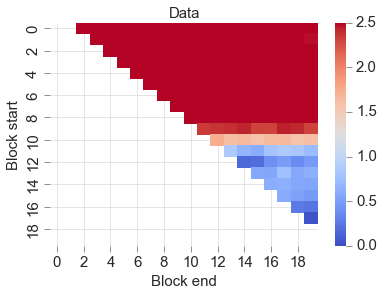

In [5]:
plt.figure()
_ = predict_1D_mmblocks(boyle_params, model_id, T=60*10,guide_length=20);

plt.figure()
_ = predict_single_mm(boyle_params,model_id)


plt.figure()
_ = predict_double_mm(boyle_params,model_id)

plt.figure()
_ = predict_block_mismatches(parameters=boyle_params, model_id=model_id, T=60*10,guide_length=20)
